In [ ]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = (12, 9)

# Camera Calibration

In this notebook we will explore a quick example of camera calibration using a 3D object.

First, load the image.

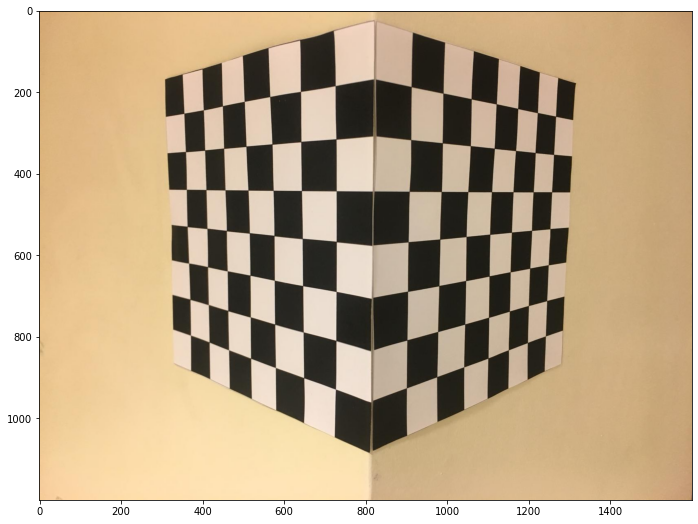

In [ ]:
img_path = 'checkerboard.png'
img = plt.imread(img_path)[:, :, :3]

plt.imshow(img)
plt.show()

Calibration works by relating pixel coordinates on the image to real world coordinates in some world frame. In order to do this, we need to find points in the image of which we know the real world coordinates. Calibration objects are nice in that they have well defined features that can serve as these points, with measured coordinates for these features. Shown above is our calibration object. Each smaller square has dimensions 18mm x 18mm.

(2 points) Convert the image to grayscale, and use OpenCV's `cv2.cornerHarris()` to find the corners of the pattern in the calibration object. `cv2.cornerHarris()` returns a heatmap of "cornerness" scores. Pick a threshold on the scores. Display the thresholded scores by making a copy of the heatmap, setting all pixels with strong response to 1.0 and others to 0.0.

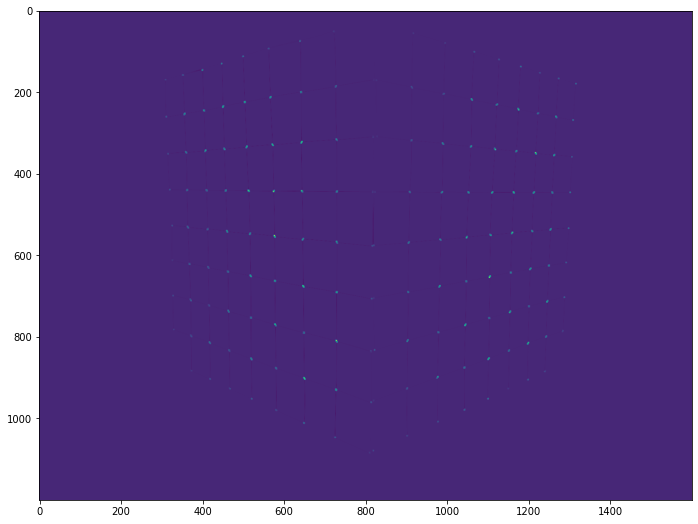

In [ ]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)
dst = cv2.cornerHarris(gray,2,3,0.04)

img_ = img.copy()
dst = cv2.dilate(dst,None)
img_[dst>0.01*dst.max()] = 1
img_[dst<=0.01*dst.max()] = 0
_ = plt.imshow(dst)

In [ ]:
corners = []
for i in range(dst.shape[0]):
  for j in range(dst.shape[1]):
    if dst[i, j] == 1:
      corners.append((i, j))

Now that we have found the corners of the object, we need to know the pixel coordinates and the coordinates in the real world. Below are pixel coordinates corresponding to six of the corners of the calibration object. We can mark their locations in the image.

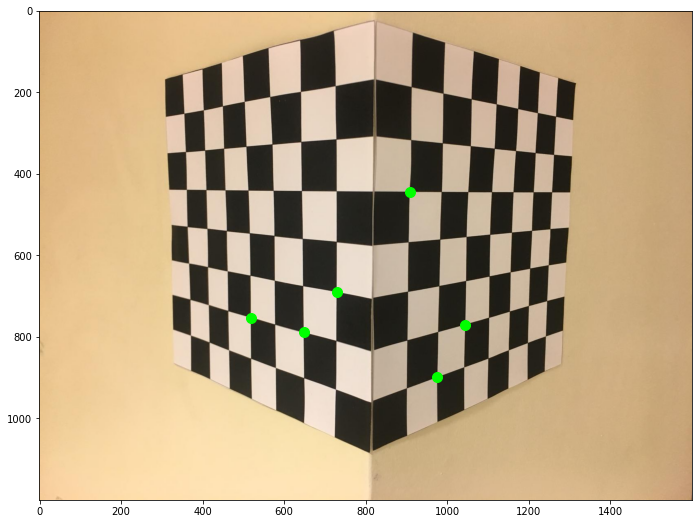

In [ ]:
corners = [
    (648, 789),
    (729, 690),
    (519, 753),
    (1044, 770),
    (976, 899),
    (908, 445),
]

plt.imshow(img)
for x, y in corners:
    plt.plot(x, y, color=(0, 1, 0), marker='o', markersize=10)
plt.show()

Now that we have the pixel coordinates, we need the corresponding real world coordinates for those corners. Below are the real world coordinates for the corners (in the same order).

In [ ]:
# Real world coordinates in (x, y, z).
locations = [
    (0, 90, 36),
    (0, 72, 18),
    (0, 90, 72),
    (54, 90, 0),
    (36, 108, 0),
    (18, 36, 0),
]

(2 points) Now that we have the real world coordinates and the pixel coordinates, we can find $p$, the projection matrix. To do this, we can set up the equation $Ap=0$ in the slides. Set up $A$ below. Refer to the slides in the lecture on how to construct $A$.

In [ ]:
locations = np.array(locations)
corners = np.array(corners)
A = []
# For only 6 points
for i in range(len(locations)):
  a = np.hstack((locations[i], 1, 0, 0, 0, 0, locations[i]*corners[i][0], corners[i][0]))
  A.append(a)
  b = np.hstack((0, 0, 0, 0, locations[i], 1, locations[i]*corners[i][1], corners[i][1]))
  A.append(b)

A = np.stack(A, axis=0)
print(A)
print(A.shape)

[[     0     90     36      1      0      0      0      0      0  58320
   23328    648]
 [     0      0      0      0      0     90     36      1      0  71010
   28404    789]
 [     0     72     18      1      0      0      0      0      0  52488
   13122    729]
 [     0      0      0      0      0     72     18      1      0  49680
   12420    690]
 [     0     90     72      1      0      0      0      0      0  46710
   37368    519]
 [     0      0      0      0      0     90     72      1      0  67770
   54216    753]
 [    54     90      0      1      0      0      0      0  56376  93960
       0   1044]
 [     0      0      0      0     54     90      0      1  41580  69300
       0    770]
 [    36    108      0      1      0      0      0      0  35136 105408
       0    976]
 [     0      0      0      0     36    108      0      1  32364  97092
       0    899]
 [    18     36      0      1      0      0      0      0  16344  32688
       0    908]
 [     0      0      

A trivial solution is when the projection matrix is all zeros, but that obviously isn't useful for us. Additionally, since our input data may be noisy, there may not be a perfect $p$ that exactly satisfies $Ap=0$. Hence we want to find the least squares solution. As shown in the appendix of the lecture slides, the eigenvector $p$ with the smallest eigenvalue $\lambda$ of matrix $A^T A$ is the solution to our problem.

(2 points) In the cell below, find the eigenvectors of $A^T A$, extract the eigenvector corresponding to the smallest eigenvalue, and reshape it into a 3x4 matrix $P$. Print the result. Since $A^T A$ is real and symmetric, you may want to use [`np.linalg.eigh()`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.eigh.html) instead of `np.linalg.eig()` for faster execution.

Alternatively, you can choose to perform singular value decomposition on $A$ and recover $P$ from the SVD results.

In [ ]:
tmp = np.matmul(A.transpose(), A)
eigval, eigvec = np.linalg.eigh(tmp)
print(eigval[0])#smallest eigenvalue
print(eigvec[:, 0])#vector with smallest eigenvalue
np.set_printoptions(precision=5, suppress=True)

5.258797905477142e-06
[ 1.04123601e-02  3.23370299e-04 -2.48218181e-03  9.78761419e-01
  2.39548213e-03  9.15488848e-03  2.43527185e-03  2.04485960e-01
 -5.02917174e-06 -4.91915755e-07 -5.07715313e-06 -1.18836071e-03]


In [ ]:
P = eigvec[:, 0].reshape(3, 4)
P

array([[ 0.01041,  0.00032, -0.00248,  0.97876],
       [ 0.0024 ,  0.00915,  0.00244,  0.20449],
       [-0.00001, -0.     , -0.00001, -0.00119]])

(1 point) Now that we have the projection matrix $P$, we can verify that it can map the 3D world coordinates to 2D image coordinates. In the cell below, print the projection results using $P$ along side the original 2D corner coordinates to verify that they are close. 

In [ ]:
print('P:','\n',  P, '\n', '\ncorners:', '\n', corners)

P: 
 [[ 0.01041  0.00032 -0.00248  0.97876]
 [ 0.0024   0.00915  0.00244  0.20449]
 [-0.00001 -0.      -0.00001 -0.00119]] 
 
corners: 
 [[ 648  789]
 [ 729  690]
 [ 519  753]
 [1044  770]
 [ 976  899]
 [ 908  445]]


(1 point) Given the projection matrix $P$, we can recover the extrinsic rotation $R$ and the intrinsic matrix $K$ via QR Decomposition. To do so, first normalize $P$ so the L2 norm of `P[2, :3]` is 1. Print the result.

In [ ]:
test_location = locations[0, :]
test_location = test_location.reshape(-1,1)
print(test_location)
tl = np.append(test_location, np.ones((1,1)), axis=0)
tmp = np.matmul(P, tl)
print(tmp)

[[ 0]
 [90]
 [36]]
[[ 0.91851]
 [ 1.1161 ]
 [-0.00142]]


In [ ]:
# https://numpy.org/doc/stable/reference/generated/numpy.linalg.eigh.html
row_sums = P.sum(axis=1)
P_norm = P / row_sums[:, np.newaxis]
P_norm[2, :3] = 1
print(P_norm)

[[ 0.01055  0.00033 -0.00251  0.99164]
 [ 0.01096  0.0419   0.01115  0.93598]
 [ 1.       1.       1.       0.99116]]


(1 point) Using `scipy.linalg.rq()`, decompose `P[:3, :3]` into an upper triangular matrix $K$ and an orthonormal matrix $R$. Print both matrices.

In [ ]:
import scipy.linalg
K, R = scipy.linalg.rq(P_norm[:3, :3])  
print(K)
print(R)

[[ 0.00922  0.00306 -0.00483]
 [ 0.      -0.02519 -0.03696]
 [ 0.       0.      -1.73205]]
[[ 0.70501  0.00417 -0.70918]
 [ 0.41186 -0.81649  0.40463]
 [-0.57735 -0.57735 -0.57735]]


You may notice that the intrinsic matrix $K$ has negative values on its diagonal, which does not seem right since the focus length of our camera should be a positive value. This is because `scipy.linalg.rq()` does not force positive diagonal values. We can do so manually by manipulating the matrices a little bit.

In [ ]:
S = np.diag(np.sign(np.diag(K)))
K = K @ S
R = S @ R
print(K)
print(R)

[[ 0.00922 -0.00306  0.00483]
 [ 0.       0.02519  0.03696]
 [ 0.       0.       1.73205]]
[[ 0.70501  0.00417 -0.70918]
 [-0.41186  0.81649 -0.40463]
 [ 0.57735  0.57735  0.57735]]


(1 point) Using $K$ we can then recover the extrinsic translation $t$. Do so below, and print the results.

In [ ]:
P_sub = np.array([row[3] for row in P])
P_sub = P_sub.reshape(-1,1)
t = np.matmul(np.linalg.inv(K), P_sub)
print(t)

[[108.82469]
 [  8.1194 ]
 [ -0.00069]]
